In [8]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
from datetime import datetime, timezone
import logging

logging.basicConfig(
    level=logging.INFO,  # Set the logging level
    format='%(asctime)s - %(levelname)s - %(message)s',  # Format for the log messages
    handlers=[
        logging.StreamHandler()  # Log to the console
    ]
)

%reload_ext autoreload
%autoreload 2
from data.raw.retrievers.alpaca_markets_retriever import AlpacaMarketsRetriever
from config.constants import *
from data.processed.dataset_creation import DatasetCreator
from data.processed.indicators import *
from data.processed.targets import Balanced3ClassClassification
from data.processed.normalization import ZScoreOverWindowNormalizer, ZScoreNormalizer, MinMaxNormalizer
from data.processed.dataset_pytorch import DatasetPytorch
from modeling.trainer import Trainer
from observability.mlflow_integration import log_experiment

from config.experiments.cur_experiment import config


In [9]:
retriever = AlpacaMarketsRetriever()

retrieval_result = retriever.bars(
    symbol_or_symbols=config.data_config.symbol_or_symbols, 
    start=config.data_config.start, 
    end=config.data_config.end)

In [10]:
dataset_creator = DatasetCreator(
    features=config.data_config.features,
    target=config.data_config.target,
    normalizer=config.data_config.normalizer,
    missing_values_handler=config.data_config.missing_values_handler,
    train_set_last_date=config.data_config.train_set_last_date, 
    in_seq_len=config.data_config.in_seq_len,
    multi_asset_prediction=config.data_config.multi_asset_prediction,
)

X_train, y_train, X_test, y_test = dataset_creator.create_dataset_numpy(retrieval_result)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

2025-06-24 20:28:49,607 - INFO - Processing AAPL …
2025-06-24 20:28:49,961 - INFO - Finished feature generation. 0 assets skipped due to insufficient rows.


((28372, 60, 3), (28372,), (7312, 60, 3), (7312,))

In [11]:
train_loader = DatasetPytorch(X_train, y_train).as_dataloader(
    batch_size=config.data_config.batch_size,
    shuffle=config.data_config.shuffle
)
test_loader = DatasetPytorch(X_test, y_test).as_dataloader(
    batch_size=config.data_config.batch_size,
    shuffle=config.data_config.shuffle
)

In [12]:
model = config.model_config.model
model

LSTMClassifier(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)

In [13]:
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    loss_fn=config.train_config.loss_fn,
    optimizer=config.train_config.optimizer,
    scheduler=config.train_config.scheduler,
    num_epochs=config.train_config.num_epochs,
    device=config.train_config.device,
    metrics=config.train_config.metrics,
    save_path=config.train_config.save_path
)

In [14]:
model, history = trainer.train()

2025-06-24 20:28:51,087 - INFO - Epoch 1/40


True


2025-06-24 20:29:03,052 - INFO - Train Loss: 1.0966           
2025-06-24 20:29:03,052 - INFO - Train Accuracy: 0.3562
2025-06-24 20:29:03,054 - INFO - Train Rmse: 1.1016
2025-06-24 20:29:03,055 - INFO - Val   Loss: 1.1111
2025-06-24 20:29:03,055 - INFO - Val   Accuracy: 0.3065
2025-06-24 20:29:03,056 - INFO - Val   Rmse: 1.2576
2025-06-24 20:29:03,057 - INFO - 
2025-06-24 20:29:03,059 - INFO - Epoch 2/40


False


True


2025-06-24 20:29:13,515 - INFO - Train Loss: 1.0904           
2025-06-24 20:29:13,517 - INFO - Train Accuracy: 0.3619
2025-06-24 20:29:13,519 - INFO - Train Rmse: 1.0657
2025-06-24 20:29:13,520 - INFO - Val   Loss: 1.1562
2025-06-24 20:29:13,522 - INFO - Val   Accuracy: 0.2956
2025-06-24 20:29:13,524 - INFO - Val   Rmse: 1.2749
2025-06-24 20:29:13,526 - INFO - 
2025-06-24 20:29:13,527 - INFO - Epoch 3/40


False


True


2025-06-24 20:29:24,436 - INFO - Train Loss: 1.0887           
2025-06-24 20:29:24,437 - INFO - Train Accuracy: 0.3650
2025-06-24 20:29:24,438 - INFO - Train Rmse: 1.0405
2025-06-24 20:29:24,438 - INFO - Val   Loss: 1.1825
2025-06-24 20:29:24,440 - INFO - Val   Accuracy: 0.3005
2025-06-24 20:29:24,441 - INFO - Val   Rmse: 1.2670
2025-06-24 20:29:24,442 - INFO - 
2025-06-24 20:29:24,443 - INFO - Epoch 4/40


False


True


2025-06-24 20:29:35,230 - INFO - Train Loss: 1.0874           
2025-06-24 20:29:35,231 - INFO - Train Accuracy: 0.3673
2025-06-24 20:29:35,232 - INFO - Train Rmse: 1.0228
2025-06-24 20:29:35,233 - INFO - Val   Loss: 1.1808
2025-06-24 20:29:35,234 - INFO - Val   Accuracy: 0.2986
2025-06-24 20:29:35,235 - INFO - Val   Rmse: 1.2696
2025-06-24 20:29:35,235 - INFO - 
2025-06-24 20:29:35,236 - INFO - Epoch 5/40


False


True


2025-06-24 20:29:46,295 - INFO - Train Loss: 1.0866           
2025-06-24 20:29:46,297 - INFO - Train Accuracy: 0.3741
2025-06-24 20:29:46,298 - INFO - Train Rmse: 0.9985
2025-06-24 20:29:46,299 - INFO - Val   Loss: 1.0961
2025-06-24 20:29:46,300 - INFO - Val   Accuracy: 0.3525
2025-06-24 20:29:46,300 - INFO - Val   Rmse: 1.0879
2025-06-24 20:29:46,301 - INFO - 
2025-06-24 20:29:46,302 - INFO - Epoch 6/40


False


True


2025-06-24 20:29:56,734 - INFO - Train Loss: 1.0865           
2025-06-24 20:29:56,735 - INFO - Train Accuracy: 0.3700
2025-06-24 20:29:56,737 - INFO - Train Rmse: 0.9982
2025-06-24 20:29:56,738 - INFO - Val   Loss: 1.1394
2025-06-24 20:29:56,739 - INFO - Val   Accuracy: 0.3002
2025-06-24 20:29:56,741 - INFO - Val   Rmse: 1.2672
2025-06-24 20:29:56,742 - INFO - 
2025-06-24 20:29:56,743 - INFO - Epoch 7/40


False


True


2025-06-24 20:30:06,978 - INFO - Train Loss: 1.0859           
2025-06-24 20:30:06,979 - INFO - Train Accuracy: 0.3727
2025-06-24 20:30:06,980 - INFO - Train Rmse: 0.9817
2025-06-24 20:30:06,982 - INFO - Val   Loss: 1.1133
2025-06-24 20:30:06,983 - INFO - Val   Accuracy: 0.3296
2025-06-24 20:30:06,985 - INFO - Val   Rmse: 1.1939
2025-06-24 20:30:06,985 - INFO - 
2025-06-24 20:30:06,986 - INFO - Epoch 8/40


False


True


2025-06-24 20:30:17,540 - INFO - Train Loss: 1.0856           
2025-06-24 20:30:17,541 - INFO - Train Accuracy: 0.3728
2025-06-24 20:30:17,541 - INFO - Train Rmse: 0.9923
2025-06-24 20:30:17,543 - INFO - Val   Loss: 1.1392
2025-06-24 20:30:17,544 - INFO - Val   Accuracy: 0.3006
2025-06-24 20:30:17,545 - INFO - Val   Rmse: 1.2671
2025-06-24 20:30:17,546 - INFO - 
2025-06-24 20:30:17,546 - INFO - Epoch 9/40


False


True


2025-06-24 20:30:31,503 - INFO - Train Loss: 1.0855           
2025-06-24 20:30:31,504 - INFO - Train Accuracy: 0.3707
2025-06-24 20:30:31,505 - INFO - Train Rmse: 0.9960
2025-06-24 20:30:31,506 - INFO - Val   Loss: 1.1085
2025-06-24 20:30:31,508 - INFO - Val   Accuracy: 0.3328
2025-06-24 20:30:31,510 - INFO - Val   Rmse: 1.1720
2025-06-24 20:30:31,511 - INFO - 
2025-06-24 20:30:31,512 - INFO - Epoch 10/40


False


True


2025-06-24 20:30:42,646 - INFO - Train Loss: 1.0850           
2025-06-24 20:30:42,647 - INFO - Train Accuracy: 0.3722
2025-06-24 20:30:42,648 - INFO - Train Rmse: 0.9918
2025-06-24 20:30:42,649 - INFO - Val   Loss: 1.1243
2025-06-24 20:30:42,649 - INFO - Val   Accuracy: 0.3012
2025-06-24 20:30:42,650 - INFO - Val   Rmse: 1.2668
2025-06-24 20:30:42,651 - INFO - 
2025-06-24 20:30:42,652 - INFO - Epoch 11/40


False


True


2025-06-24 20:30:53,199 - INFO - Train Loss: 1.0842           
2025-06-24 20:30:53,199 - INFO - Train Accuracy: 0.3762
2025-06-24 20:30:53,200 - INFO - Train Rmse: 0.9804
2025-06-24 20:30:53,200 - INFO - Val   Loss: 1.1445
2025-06-24 20:30:53,202 - INFO - Val   Accuracy: 0.3038
2025-06-24 20:30:53,203 - INFO - Val   Rmse: 1.2577
2025-06-24 20:30:53,205 - INFO - 
2025-06-24 20:30:53,206 - INFO - Epoch 12/40


False


True


2025-06-24 20:31:03,389 - INFO - Train Loss: 1.0840           
2025-06-24 20:31:03,390 - INFO - Train Accuracy: 0.3760
2025-06-24 20:31:03,390 - INFO - Train Rmse: 0.9770
2025-06-24 20:31:03,392 - INFO - Val   Loss: 1.1600
2025-06-24 20:31:03,393 - INFO - Val   Accuracy: 0.2969
2025-06-24 20:31:03,394 - INFO - Val   Rmse: 1.2732
2025-06-24 20:31:03,395 - INFO - 
2025-06-24 20:31:03,397 - INFO - Epoch 13/40


False


True


2025-06-24 20:31:14,148 - INFO - Train Loss: 1.0838           
2025-06-24 20:31:14,148 - INFO - Train Accuracy: 0.3750
2025-06-24 20:31:14,151 - INFO - Train Rmse: 0.9898
2025-06-24 20:31:14,152 - INFO - Val   Loss: 1.1255
2025-06-24 20:31:14,153 - INFO - Val   Accuracy: 0.3004
2025-06-24 20:31:14,154 - INFO - Val   Rmse: 1.2667
2025-06-24 20:31:14,156 - INFO - 
2025-06-24 20:31:14,158 - INFO - Epoch 14/40


False


True


2025-06-24 20:31:27,593 - INFO - Train Loss: 1.0837           
2025-06-24 20:31:27,594 - INFO - Train Accuracy: 0.3748
2025-06-24 20:31:27,595 - INFO - Train Rmse: 0.9887
2025-06-24 20:31:27,596 - INFO - Val   Loss: 1.1376
2025-06-24 20:31:27,597 - INFO - Val   Accuracy: 0.3006
2025-06-24 20:31:27,600 - INFO - Val   Rmse: 1.2674
2025-06-24 20:31:27,601 - INFO - 
2025-06-24 20:31:27,602 - INFO - Epoch 15/40


False


True


2025-06-24 20:31:38,060 - INFO - Train Loss: 1.0835           
2025-06-24 20:31:38,061 - INFO - Train Accuracy: 0.3761
2025-06-24 20:31:38,062 - INFO - Train Rmse: 0.9942
2025-06-24 20:31:38,063 - INFO - Val   Loss: 1.1205
2025-06-24 20:31:38,063 - INFO - Val   Accuracy: 0.3368
2025-06-24 20:31:38,065 - INFO - Val   Rmse: 1.1893
2025-06-24 20:31:38,065 - INFO - 
2025-06-24 20:31:38,066 - INFO - Epoch 16/40


False


True


2025-06-24 20:31:48,837 - INFO - Train Loss: 1.0834           
2025-06-24 20:31:48,838 - INFO - Train Accuracy: 0.3764
2025-06-24 20:31:48,840 - INFO - Train Rmse: 0.9834
2025-06-24 20:31:48,841 - INFO - Val   Loss: 1.1315
2025-06-24 20:31:48,841 - INFO - Val   Accuracy: 0.2986
2025-06-24 20:31:48,845 - INFO - Val   Rmse: 1.2711
2025-06-24 20:31:48,845 - INFO - 
2025-06-24 20:31:48,846 - INFO - Epoch 17/40


False


True


2025-06-24 20:32:02,071 - INFO - Train Loss: 1.0827           
2025-06-24 20:32:02,072 - INFO - Train Accuracy: 0.3772
2025-06-24 20:32:02,074 - INFO - Train Rmse: 0.9979
2025-06-24 20:32:02,075 - INFO - Val   Loss: 1.0977
2025-06-24 20:32:02,076 - INFO - Val   Accuracy: 0.3631
2025-06-24 20:32:02,078 - INFO - Val   Rmse: 1.1267
2025-06-24 20:32:02,079 - INFO - 
2025-06-24 20:32:02,080 - INFO - Epoch 18/40


False


True


2025-06-24 20:32:13,656 - INFO - Train Loss: 1.0818           
2025-06-24 20:32:13,657 - INFO - Train Accuracy: 0.3828
2025-06-24 20:32:13,658 - INFO - Train Rmse: 1.0017
2025-06-24 20:32:13,659 - INFO - Val   Loss: 1.1272
2025-06-24 20:32:13,659 - INFO - Val   Accuracy: 0.2971
2025-06-24 20:32:13,660 - INFO - Val   Rmse: 1.2703
2025-06-24 20:32:13,661 - INFO - 
2025-06-24 20:32:13,662 - INFO - Epoch 19/40


False


True


2025-06-24 20:32:23,941 - INFO - Train Loss: 1.0802           
2025-06-24 20:32:23,941 - INFO - Train Accuracy: 0.3855
2025-06-24 20:32:23,942 - INFO - Train Rmse: 1.0178
2025-06-24 20:32:23,943 - INFO - Val   Loss: 1.0956
2025-06-24 20:32:23,943 - INFO - Val   Accuracy: 0.3667
2025-06-24 20:32:23,944 - INFO - Val   Rmse: 1.1298
2025-06-24 20:32:23,945 - INFO - 
2025-06-24 20:32:23,947 - INFO - Epoch 20/40


False


True


2025-06-24 20:32:33,960 - INFO - Train Loss: 1.0779           
2025-06-24 20:32:33,961 - INFO - Train Accuracy: 0.3936
2025-06-24 20:32:33,962 - INFO - Train Rmse: 1.0396
2025-06-24 20:32:33,963 - INFO - Val   Loss: 1.1495
2025-06-24 20:32:33,963 - INFO - Val   Accuracy: 0.3004
2025-06-24 20:32:33,965 - INFO - Val   Rmse: 1.2669
2025-06-24 20:32:33,966 - INFO - 
2025-06-24 20:32:33,967 - INFO - Epoch 21/40


False


True


2025-06-24 20:32:44,079 - INFO - Train Loss: 1.0753           
2025-06-24 20:32:44,080 - INFO - Train Accuracy: 0.3992
2025-06-24 20:32:44,081 - INFO - Train Rmse: 1.0438
2025-06-24 20:32:44,082 - INFO - Val   Loss: 1.1278
2025-06-24 20:32:44,083 - INFO - Val   Accuracy: 0.3143
2025-06-24 20:32:44,085 - INFO - Val   Rmse: 1.2381
2025-06-24 20:32:44,085 - INFO - 
2025-06-24 20:32:44,086 - INFO - Epoch 22/40


False


True


2025-06-24 20:32:54,186 - INFO - Train Loss: 1.0737           
2025-06-24 20:32:54,187 - INFO - Train Accuracy: 0.4018
2025-06-24 20:32:54,188 - INFO - Train Rmse: 1.0429
2025-06-24 20:32:54,189 - INFO - Val   Loss: 1.0880
2025-06-24 20:32:54,189 - INFO - Val   Accuracy: 0.4087
2025-06-24 20:32:54,191 - INFO - Val   Rmse: 1.0436
2025-06-24 20:32:54,191 - INFO - 
2025-06-24 20:32:54,193 - INFO - Epoch 23/40


False


True


2025-06-24 20:33:04,435 - INFO - Train Loss: 1.0742           
2025-06-24 20:33:04,436 - INFO - Train Accuracy: 0.3992
2025-06-24 20:33:04,436 - INFO - Train Rmse: 1.0478
2025-06-24 20:33:04,438 - INFO - Val   Loss: 1.1072
2025-06-24 20:33:04,438 - INFO - Val   Accuracy: 0.3504
2025-06-24 20:33:04,439 - INFO - Val   Rmse: 1.1848
2025-06-24 20:33:04,440 - INFO - 
2025-06-24 20:33:04,441 - INFO - Epoch 24/40


False


True


2025-06-24 20:33:14,645 - INFO - Train Loss: 1.0731           
2025-06-24 20:33:14,645 - INFO - Train Accuracy: 0.4004
2025-06-24 20:33:14,646 - INFO - Train Rmse: 1.0544
2025-06-24 20:33:14,648 - INFO - Val   Loss: 1.1397
2025-06-24 20:33:14,648 - INFO - Val   Accuracy: 0.3055
2025-06-24 20:33:14,649 - INFO - Val   Rmse: 1.2600
2025-06-24 20:33:14,650 - INFO - 
2025-06-24 20:33:14,651 - INFO - Epoch 25/40


False


True


2025-06-24 20:33:24,813 - INFO - Train Loss: 1.0727           
2025-06-24 20:33:24,814 - INFO - Train Accuracy: 0.4015
2025-06-24 20:33:24,814 - INFO - Train Rmse: 1.0521
2025-06-24 20:33:24,815 - INFO - Val   Loss: 1.0775
2025-06-24 20:33:24,816 - INFO - Val   Accuracy: 0.4213
2025-06-24 20:33:24,819 - INFO - Val   Rmse: 0.9702
2025-06-24 20:33:24,819 - INFO - 
2025-06-24 20:33:24,820 - INFO - Epoch 26/40


False


True


2025-06-24 20:33:34,852 - INFO - Train Loss: 1.0731           
2025-06-24 20:33:34,853 - INFO - Train Accuracy: 0.4032
2025-06-24 20:33:34,854 - INFO - Train Rmse: 1.0466
2025-06-24 20:33:34,856 - INFO - Val   Loss: 1.1081
2025-06-24 20:33:34,856 - INFO - Val   Accuracy: 0.3470
2025-06-24 20:33:34,857 - INFO - Val   Rmse: 1.1900
2025-06-24 20:33:34,858 - INFO - 
2025-06-24 20:33:34,859 - INFO - Epoch 27/40


False


True


2025-06-24 20:33:45,119 - INFO - Train Loss: 1.0728           
2025-06-24 20:33:45,121 - INFO - Train Accuracy: 0.4041
2025-06-24 20:33:45,122 - INFO - Train Rmse: 1.0465
2025-06-24 20:33:45,123 - INFO - Val   Loss: 1.1133
2025-06-24 20:33:45,123 - INFO - Val   Accuracy: 0.3397
2025-06-24 20:33:45,125 - INFO - Val   Rmse: 1.2003
2025-06-24 20:33:45,125 - INFO - 
2025-06-24 20:33:45,126 - INFO - Epoch 28/40


False


True


2025-06-24 20:33:55,255 - INFO - Train Loss: 1.0725           
2025-06-24 20:33:55,255 - INFO - Train Accuracy: 0.4011
2025-06-24 20:33:55,256 - INFO - Train Rmse: 1.0555
2025-06-24 20:33:55,257 - INFO - Val   Loss: 1.0947
2025-06-24 20:33:55,258 - INFO - Val   Accuracy: 0.3884
2025-06-24 20:33:55,259 - INFO - Val   Rmse: 1.0953
2025-06-24 20:33:55,260 - INFO - 
2025-06-24 20:33:55,261 - INFO - Epoch 29/40


False


True


2025-06-24 20:34:05,640 - INFO - Train Loss: 1.0720           
2025-06-24 20:34:05,642 - INFO - Train Accuracy: 0.4044
2025-06-24 20:34:05,645 - INFO - Train Rmse: 1.0480
2025-06-24 20:34:05,646 - INFO - Val   Loss: 1.0869
2025-06-24 20:34:05,647 - INFO - Val   Accuracy: 0.4042
2025-06-24 20:34:05,648 - INFO - Val   Rmse: 1.0486
2025-06-24 20:34:05,649 - INFO - 
2025-06-24 20:34:05,649 - INFO - Epoch 30/40


False


True


2025-06-24 20:34:15,955 - INFO - Train Loss: 1.0720           
2025-06-24 20:34:15,956 - INFO - Train Accuracy: 0.4031
2025-06-24 20:34:15,957 - INFO - Train Rmse: 1.0513
2025-06-24 20:34:15,958 - INFO - Val   Loss: 1.0815
2025-06-24 20:34:15,959 - INFO - Val   Accuracy: 0.4169
2025-06-24 20:34:15,960 - INFO - Val   Rmse: 1.0087
2025-06-24 20:34:15,961 - INFO - 
2025-06-24 20:34:15,962 - INFO - Epoch 31/40


False


True


2025-06-24 20:34:26,413 - INFO - Train Loss: 1.0709           
2025-06-24 20:34:26,415 - INFO - Train Accuracy: 0.4062
2025-06-24 20:34:26,416 - INFO - Train Rmse: 1.0433
2025-06-24 20:34:26,416 - INFO - Val   Loss: 1.0960
2025-06-24 20:34:26,417 - INFO - Val   Accuracy: 0.3779
2025-06-24 20:34:26,417 - INFO - Val   Rmse: 1.1187
2025-06-24 20:34:26,418 - INFO - 
2025-06-24 20:34:26,421 - INFO - Epoch 32/40


False


True


2025-06-24 20:34:36,904 - INFO - Train Loss: 1.0711           
2025-06-24 20:34:36,905 - INFO - Train Accuracy: 0.4059
2025-06-24 20:34:36,906 - INFO - Train Rmse: 1.0556
2025-06-24 20:34:36,907 - INFO - Val   Loss: 1.0989
2025-06-24 20:34:36,908 - INFO - Val   Accuracy: 0.3715
2025-06-24 20:34:36,909 - INFO - Val   Rmse: 1.1317
2025-06-24 20:34:36,909 - INFO - 
2025-06-24 20:34:36,910 - INFO - Epoch 33/40


False


True


2025-06-24 20:34:47,082 - INFO - Train Loss: 1.0707           
2025-06-24 20:34:47,084 - INFO - Train Accuracy: 0.4043
2025-06-24 20:34:47,085 - INFO - Train Rmse: 1.0506
2025-06-24 20:34:47,085 - INFO - Val   Loss: 1.1047
2025-06-24 20:34:47,088 - INFO - Val   Accuracy: 0.3623
2025-06-24 20:34:47,089 - INFO - Val   Rmse: 1.1568
2025-06-24 20:34:47,090 - INFO - 
2025-06-24 20:34:47,090 - INFO - Epoch 34/40


False


True


2025-06-24 20:34:57,227 - INFO - Train Loss: 1.0708           
2025-06-24 20:34:57,228 - INFO - Train Accuracy: 0.4036
2025-06-24 20:34:57,231 - INFO - Train Rmse: 1.0554
2025-06-24 20:34:57,231 - INFO - Val   Loss: 1.1162
2025-06-24 20:34:57,232 - INFO - Val   Accuracy: 0.3365
2025-06-24 20:34:57,234 - INFO - Val   Rmse: 1.2058
2025-06-24 20:34:57,236 - INFO - 
2025-06-24 20:34:57,237 - INFO - Epoch 35/40


False


True


2025-06-24 20:35:07,435 - INFO - Train Loss: 1.0710           
2025-06-24 20:35:07,436 - INFO - Train Accuracy: 0.4051
2025-06-24 20:35:07,437 - INFO - Train Rmse: 1.0527
2025-06-24 20:35:07,438 - INFO - Val   Loss: 1.1069
2025-06-24 20:35:07,439 - INFO - Val   Accuracy: 0.3548
2025-06-24 20:35:07,441 - INFO - Val   Rmse: 1.1780
2025-06-24 20:35:07,441 - INFO - 
2025-06-24 20:35:07,442 - INFO - Epoch 36/40


False


True


2025-06-24 20:35:17,588 - INFO - Train Loss: 1.0707           
2025-06-24 20:35:17,588 - INFO - Train Accuracy: 0.4045
2025-06-24 20:35:17,590 - INFO - Train Rmse: 1.0562
2025-06-24 20:35:17,590 - INFO - Val   Loss: 1.1012
2025-06-24 20:35:17,591 - INFO - Val   Accuracy: 0.3652
2025-06-24 20:35:17,592 - INFO - Val   Rmse: 1.1393
2025-06-24 20:35:17,592 - INFO - 
2025-06-24 20:35:17,593 - INFO - Epoch 37/40


False


True


2025-06-24 20:35:27,793 - INFO - Train Loss: 1.0708           
2025-06-24 20:35:27,794 - INFO - Train Accuracy: 0.4053
2025-06-24 20:35:27,795 - INFO - Train Rmse: 1.0533
2025-06-24 20:35:27,796 - INFO - Val   Loss: 1.1156
2025-06-24 20:35:27,796 - INFO - Val   Accuracy: 0.3498
2025-06-24 20:35:27,798 - INFO - Val   Rmse: 1.1827
2025-06-24 20:35:27,799 - INFO - 
2025-06-24 20:35:27,800 - INFO - Epoch 38/40


False


True


2025-06-24 20:35:37,921 - INFO - Train Loss: 1.0707           
2025-06-24 20:35:37,922 - INFO - Train Accuracy: 0.4062
2025-06-24 20:35:37,923 - INFO - Train Rmse: 1.0532
2025-06-24 20:35:37,923 - INFO - Val   Loss: 1.0888
2025-06-24 20:35:37,924 - INFO - Val   Accuracy: 0.3963
2025-06-24 20:35:37,925 - INFO - Val   Rmse: 1.0734
2025-06-24 20:35:37,926 - INFO - 
2025-06-24 20:35:37,926 - INFO - Epoch 39/40


False


True


2025-06-24 20:35:48,570 - INFO - Train Loss: 1.0705           
2025-06-24 20:35:48,572 - INFO - Train Accuracy: 0.4072
2025-06-24 20:35:48,573 - INFO - Train Rmse: 1.0524
2025-06-24 20:35:48,574 - INFO - Val   Loss: 1.1293
2025-06-24 20:35:48,574 - INFO - Val   Accuracy: 0.3256
2025-06-24 20:35:48,575 - INFO - Val   Rmse: 1.2216
2025-06-24 20:35:48,577 - INFO - 
2025-06-24 20:35:48,578 - INFO - Epoch 40/40


False


True


2025-06-24 20:35:58,782 - INFO - Train Loss: 1.0710           
2025-06-24 20:35:58,783 - INFO - Train Accuracy: 0.4049
2025-06-24 20:35:58,784 - INFO - Train Rmse: 1.0598
2025-06-24 20:35:58,785 - INFO - Val   Loss: 1.1272
2025-06-24 20:35:58,786 - INFO - Val   Accuracy: 0.3211
2025-06-24 20:35:58,787 - INFO - Val   Rmse: 1.2281
2025-06-24 20:35:58,787 - INFO - 


False


In [15]:
log_experiment(
    config=config, 
    model=model, 
    history=history,
    input_data_sample=next(iter(train_loader))[0].to(trainer.device))

2025/06/24 20:36:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'LSTM Default' already exists. Creating a new version of this model...
2025/06/24 20:36:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM Default, version 4
Created version '4' of model 'LSTM Default'.


🏃 View run treasured-koi-452 at: http://127.0.0.1:8080/#/experiments/311174949180547184/runs/b50f603f77924c869fc09db315e03a0b
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/311174949180547184


In [20]:
import itertools 
from sklearn.base import clone
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.datasets import make_classification
import lightgbm as lgb


def evaluate_model_accuracy(model, param_grid=None):
    def evaluate_cur_model(cur_model, best_accuracy): 
        cur_model = cur_model.fit(X_train, y_train)
        train_preds = cur_model.predict(X_train)
        test_preds = cur_model.predict(X_test)

        train_accuracy = accuracy_score(y_train, train_preds)
        test_accuracy = accuracy_score(y_test, test_preds)

        return train_accuracy, test_accuracy


    best_accuracy = 0
    best_params = None 
    if param_grid:
        keys, values = zip(*param_grid.items())
        param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

        for param_compbination in param_combinations: 
            cur_model = clone(model).set_params(**param_compbination)
            cur_accuracy_train, cur_accuracy_test = evaluate_cur_model(cur_model, best_accuracy)
            if cur_accuracy_test > best_accuracy: 
                best_accuracy = cur_accuracy_test
                best_params = param_compbination
    else: 
        cur_accuracy_train, cur_accuracy_test = evaluate_cur_model(model, best_accuracy)
        if cur_accuracy_test > best_accuracy: 
            best_accuracy = cur_accuracy_test
            best_params = None

    print(f'Train accuracy: {cur_accuracy_train}, Test accuracy: {best_accuracy}, bestparams: {best_params}')

lgb_model = lgb.LGBMClassifier(
    n_estimators=1000, 
    learning_rate=0.001,
    max_depth=5,
    num_leaves=15, 
    objective='multiclass', 
    num_class=3
    )
evaluate_model_accuracy(lgb_model)

c:\Users\ikurnosau\anaconda3\envs\mldl\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9435
[LightGBM] [Info] Number of data points in the train set: 28431, number of used features: 37
[LightGBM] [Info] Start training from score -1.083844
[LightGBM] [Info] Start training from score -1.124263
[LightGBM] [Info] Start training from score -1.088220


c:\Users\ikurnosau\anaconda3\envs\mldl\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ikurnosau\anaconda3\envs\mldl\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Train accuracy: 0.44096232985121875, Test accuracy: 0.41866775200108536, bestparams: None


In [32]:
# lgb_model = lgb.LGBMRegressor(
#     n_estimators=1000, 
#     learning_rate=0.01,
#     max_depth=5,
#     num_leaves=31, 
# ).fit(X_train, y_train)

lgb_model = lgb.LGBMRegressor(
    n_estimators=30_000,
    learning_rate=0.001,
    max_depth=10,
    num_leaves=2**10,
    colsample_bytree=0.1,
    min_data_in_leaf=10000,
).fit(X_train, y_train)

c:\Users\ikurnosau\anaconda3\envs\mldl\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9435
[LightGBM] [Info] Number of data points in the train set: 5751244, number of used features: 37
[LightGBM] [Info] Start training from score 0.999914
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


def eval_regression(test_preds, y_test):
    mse = mean_squared_error(y_test, test_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, test_preds)
    baseline = mean_absolute_error(y_test, np.ones_like(y_test))

    print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}, Baseline MAE: {baseline}')

In [35]:
test_preds = lgb_model.predict(X_test)
eval_regression(test_preds, y_test)

c:\Users\ikurnosau\anaconda3\envs\mldl\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
MSE: 0.6345418442933104, RMSE: 0.7965813481957197, MAE: 0.6509043914988887, Baseline MAE: 0.6390581130981445


In [36]:
long_threshold = pd.Series(test_preds).quantile(24/25)
long_preds = test_preds[test_preds > long_threshold]
long_trues = y_test[test_preds > long_threshold]
len(long_preds), len(long_trues), len(test_preds)

(21598, 21598, 539929)

In [37]:
true_values_counts = pd.Series(long_trues).value_counts()

In [38]:
true_values_counts

2.0    8893
1.0    7644
0.0    5061
Name: count, dtype: int64

In [39]:
top_2_preds_accuracy = (true_values_counts[2] + true_values_counts[1] / 2) / len(long_preds)
top_2_preds_accuracy

np.float64(0.5887119177701639)

In [58]:
import lgb

lgb_model = lgb.LGBMClassifier(
    n_estimators=1000, 
    learning_rate=0.001,
    max_depth=5,
    num_leaves=31, 
    objective='multiclass', 
    num_class=3
    ).fit(X_train, y_train)

ModuleNotFoundError: No module named 'lgb'

In [41]:
test_preds = lgb_model.predict_proba(X_test)
test_preds.shape

c:\Users\ikurnosau\anaconda3\envs\mldl\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(539929, 3)

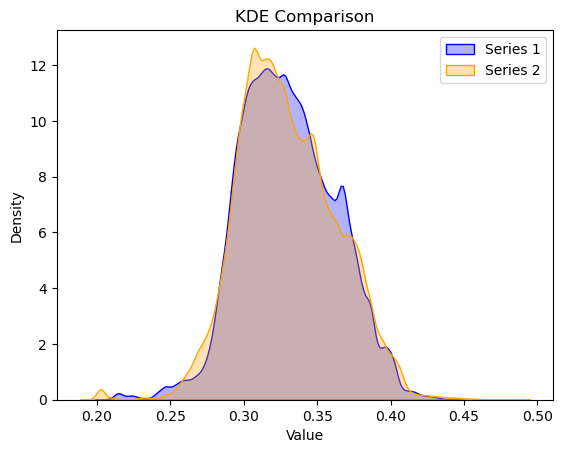

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot( pd.Series(test_preds[:, 2]), label='Series 1', color='blue', fill=True, alpha=0.3)
sns.kdeplot( pd.Series(test_preds[:, 0]), label='Series 2', color='orange', fill=True, alpha=0.3)

plt.title("KDE Comparison")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()


In [75]:
pd.Series(test_preds[:, 2]).mean(), pd.Series(test_preds[:, 2]).median()

(np.float64(0.3300353326739405), np.float64(0.3278782464040516))

In [76]:
pd.Series(test_preds[:, 0]).mean(), pd.Series(test_preds[:, 0]).median()

(np.float64(0.3296229889778825), np.float64(0.32639572660174665))

In [65]:
long_threshold = pd.Series(test_preds[:, 2]).quantile(45/50)
long_trues = y_test[test_preds[:, 2] > long_threshold]
len(long_trues), len(test_preds)

(53993, 539929)

In [66]:
true_values_counts = pd.Series(long_trues).value_counts()
true_values_counts

2.0    23019
0.0    21227
1.0     9747
Name: count, dtype: int64

In [67]:
top_2_preds_accuracy = (true_values_counts[2] + true_values_counts[0] / 2) / len(long_trues)
top_2_preds_accuracy

np.float64(0.6229048209953142)

In [48]:
long_threshold = pd.Series(test_preds[:, 2]).quantile(24/25)
print(long_threshold)
long_trues = y_test[test_preds[:, 2] > long_threshold]
len(long_trues), len(test_preds)

0.3871547218694559


(21598, 539929)

In [6]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
import torch 


clf = TabNetClassifier(
    scheduler_params = {
        "gamma": 0.5,
        "step_size": 10},
    scheduler_fn=torch.optim.lr_scheduler.StepLR
)  #TabNetRegressor()

c:\Users\ikurnosau\anaconda3\envs\mldl\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [7]:
clf.fit(
  X_train, y_train,
  eval_set=[(X_test, y_test)],
  patience=100,
)

epoch 0  | loss: 1.07199 | val_0_accuracy: 0.39509 |  0:10:50s
epoch 1  | loss: 1.06552 | val_0_accuracy: 0.3997  |  0:21:50s
epoch 2  | loss: 1.06376 | val_0_accuracy: 0.4006  |  0:32:43s
epoch 3  | loss: 1.06284 | val_0_accuracy: 0.40055 |  0:43:44s
epoch 4  | loss: 1.06231 | val_0_accuracy: 0.40007 |  0:55:49s
epoch 5  | loss: 1.06198 | val_0_accuracy: 0.39933 |  1:06:40s
epoch 6  | loss: 1.06172 | val_0_accuracy: 0.40132 |  1:17:30s
epoch 7  | loss: 1.06146 | val_0_accuracy: 0.40285 |  1:28:21s
epoch 8  | loss: 1.0613  | val_0_accuracy: 0.40325 |  1:39:13s
epoch 9  | loss: 1.06115 | val_0_accuracy: 0.40194 |  1:50:04s
epoch 10 | loss: 1.06046 | val_0_accuracy: 0.40254 |  2:00:55s
epoch 11 | loss: 1.06045 | val_0_accuracy: 0.40363 |  2:11:47s
epoch 12 | loss: 1.06111 | val_0_accuracy: 0.40192 |  2:22:46s
epoch 13 | loss: 1.06038 | val_0_accuracy: 0.40345 |  2:33:37s
epoch 14 | loss: 1.06031 | val_0_accuracy: 0.40465 |  2:44:29s
epoch 15 | loss: 1.06035 | val_0_accuracy: 0.40166 |  2

KeyboardInterrupt: 